### Overfit 발생 모델, 훈련/검증/테스트로 데이터 구성

In [1]:
%autosave 0
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential      # class
from tensorflow.keras.models import load_model      # model 사용
from tensorflow.keras.layers import Dense           # 전결합
from tensorflow.keras.layers import Dropout         # 노드의 비활성화
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지
from tensorflow.keras import regularizers   # L1, L2 규제 적용

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  # K 겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

# Jupyter에게 matplotlib 그래프를 출력 영역에 표시할 것을 지시하는 명령
%matplotlib inline

Autosave disabled


In [2]:
data = np.loadtxt('./survival.csv', delimiter=',', dtype=np.float64)
X = data[:, 0:17] # 0 ~ 16: 17개, 독립 변수
print(X.shape)
Y = data[:, 17]   # 17: 1개, 종속 변수, target
print(Y.shape)

(470, 17)
(470,)


In [4]:
# 생존자, 사망자
rpt = [0] * 2
for row in Y:
    # print(row)
    row = int(row)
    rpt[row] = rpt[row] + 1

print('사망자: {0:.0f}, 생존자: {1:.0f}'.format(rpt[0], rpt[1]))

사망자: 400, 생존자: 70


In [5]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기(x_train_all), 10%: 테스트(x_test)
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                          stratify=Y,
                                                          test_size=0.1,
                                                          random_state=seed)
# Overfit
# 나머지 데이터 90%를 분할, 70%: 훈련(x_train), 30%: 검증(x_val)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.3,
                                                  random_state=seed)

print(y_val[0:100])
print(y_val.shape)

[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
(127,)


In [6]:
def overfit1():
    tf.random.set_seed(0)
    model = Sequential()
    # model.add(Dense(128, input_dim=17, activation='linear')) # 첫번째 은닉층
    model.add(Dense(128, input_shape=(17, ), activation='relu')) # 첫번째 은닉층
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # 출력층, 입력: 15, 출력 1

    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # 오차가 16번 증가되면 종료, Overfit 발생을위해 과도한 학습 진행
    # es = EarlyStopping(monitor='loss', patience=16, restore_best_weights=True)

    # Overfit 발생안됨
    es = EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)

    # 학습
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                     epochs=1000, 
                     batch_size=2, callbacks=[es])
    
    return model, hist

In [7]:
model, hist = overfit1()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                495       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16        
Total params: 13,151
Trainable params: 13,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
148/148 [==============================] - 1s 4ms/step - loss: 0.6514 - accuracy: 0.8524 - val_loss: 0.46

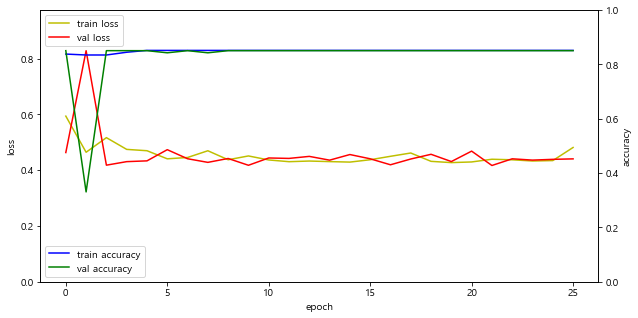

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.9740]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.4600207209587097 /정확도: 85.10638475418091 %


In [20]:
# 생존자의 규칙 파악에 실패하여 생존자 예측이 1~2명 정도만 가능하다.
# 85.10638475418091 % 신뢰할 수 없다.
# 생존자의 데이터를 증가 시켜야한다.
# 사망 생존에 영향을 많이 주는 변수를 주성분 분석등을 이용하여 파악한다.
# 기존 생존자 데이터가 규칙성이 없는 경우 데이터 증폭을 위해 기존 데이터의
# 중앙값이나 평균등을 이용하여 데이터를 추가해도 정확도 개선은 어렵다.
# 재료(데이터)가 부실하면 생산 제품도 부실하다.